In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import sys
sys.path.append('../')
from utils import get_mat
import networkx as nx

### Load data, merge experiments, calculate normalized scores

In [2]:
directory_path = '../our_results'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    
    # Define the pattern
    pattern = re.compile(r'([\w-]+)_(\d+\.\d+)_(\d+\.\d+)_(\d+\.\d+)_(\d+)\.csv')

    # Use the pattern to extract values
    match = pattern.match(file)

    # Check if the string matches the pattern
    if match:
        # Extract values from the match object
        df['dataset'] = match.group(1)
        e1 = float(match.group(3))
        df['e1'] = e1
        e2 = float(match.group(4))
        df['e2'] = e2
        df['e3'] = 1.0 - e1 - e2
    else:
        print(file + " doesn't match!")
        continue
        
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
dfs = pd.concat(dfs, ignore_index=True)

# take the average of all experiments
dfs = dfs.groupby(['eps', 'N', 'dataset', 'e1', 'e2']).mean().reset_index()
dfs = dfs.drop('exper', axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3
0,0.5,5.0,Bitcoin,0.1,0.1,0.143892,0.027027,0.051316,3.504935,0.2600,0.978952,0.415654,0.8
1,0.5,5.0,Bitcoin,0.1,0.3,0.137943,0.016216,0.050437,3.395143,0.2100,0.982516,0.439216,0.6
2,0.5,5.0,Bitcoin,0.1,0.4,0.149094,0.008108,0.063115,3.354910,0.2500,0.972154,0.435042,0.5
3,0.5,5.0,Bitcoin,0.1,0.5,0.147347,0.013514,0.052128,3.343561,0.2400,0.965051,0.434195,0.4
4,0.5,5.0,Bitcoin,0.1,0.7,0.167034,0.005405,0.042983,2.826524,0.2900,0.933224,0.381953,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,3.5,35.0,Facebook,0.4,0.4,0.211623,0.672500,0.008383,0.332793,0.2625,0.631651,0.326553,0.2
2570,3.5,35.0,Facebook,0.4,0.5,0.242776,0.655000,0.007636,0.351442,0.1500,0.596279,0.342098,0.1
2571,3.5,35.0,Facebook,0.5,0.1,0.154159,0.712500,0.005143,0.451522,0.2125,0.525142,0.410727,0.4
2572,3.5,35.0,Facebook,0.5,0.3,0.207987,0.665000,0.008607,0.363541,0.2250,0.605318,0.335231,0.2


In [3]:
# apply Z-Score Normalization for the metrics and add graph info at the dataset level
datasets = dfs['dataset'].unique()
metrics = cols = ['nmi','evc_overlap','evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']
for dataset in datasets:
    data_path = '../data/' + dataset + '.txt'
    mat0,mid = get_mat(data_path)
    mat0_graph = nx.from_numpy_array(mat0,create_using=nx.Graph)
    dfs.loc[dfs['dataset'] == dataset,'nodes'] = mat0_graph.number_of_nodes()
    dfs.loc[dfs['dataset'] == dataset,'edges'] = mat0_graph.number_of_edges()
    
dfs.loc[:, metrics] = dfs.loc[:, metrics].apply(zscore)
    
dfs['density'] = dfs['edges']/dfs['nodes']

# invert certain metrics that are better when the values are smaller
for col in ['evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']:
    dfs[col] = -dfs[col]
    
# calculate a score based on normalized metrics. The larger the score the better.
dfs['score'] = dfs[metrics].sum(axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
0,0.5,5.0,Bitcoin,0.1,0.1,-0.339246,-1.483262,-2.802190,-0.978593,0.672623,-1.594836,-0.142082,0.8,3783.0,14124.0,3.733545,-6.667586
1,0.5,5.0,Bitcoin,0.1,0.3,-0.421542,-1.518496,-2.733043,-0.907402,1.032400,-1.606265,-0.265895,0.6,3783.0,14124.0,3.733545,-6.420245
2,0.5,5.0,Bitcoin,0.1,0.4,-0.267282,-1.544922,-3.730249,-0.881315,0.744578,-1.573033,-0.243963,0.5,3783.0,14124.0,3.733545,-7.496186
3,0.5,5.0,Bitcoin,0.1,0.5,-0.291450,-1.527305,-2.866019,-0.873955,0.816534,-1.550255,-0.239512,0.4,3783.0,14124.0,3.733545,-6.531963
4,0.5,5.0,Bitcoin,0.1,0.7,-0.019111,-1.553730,-2.146673,-0.538702,0.456757,-1.448182,0.035013,0.2,3783.0,14124.0,3.733545,-5.214627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,3.5,35.0,Facebook,0.4,0.4,0.597713,0.620447,0.574922,1.078269,0.654634,-0.481013,0.326125,0.2,4039.0,88234.0,21.845506,3.371097
2570,3.5,35.0,Facebook,0.4,0.5,1.028674,0.563411,0.633688,1.066177,1.464132,-0.367573,0.244443,0.1,4039.0,88234.0,21.845506,4.632952
2571,3.5,35.0,Facebook,0.5,0.1,-0.197222,0.750814,0.829778,1.001284,1.014411,-0.139431,-0.116189,0.4,4039.0,88234.0,21.845506,3.143445
2572,3.5,35.0,Facebook,0.5,0.3,0.547416,0.596003,0.557273,1.058331,0.924467,-0.396560,0.280527,0.2,4039.0,88234.0,21.845506,3.567458


In [4]:
# top 10 combos for Chamelon
dfs[dfs['dataset'] == "Chamelon"][dfs['eps'] == 0.5].nlargest(10, "score")

/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_44893/4282099312.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfs[dfs['dataset'] == "Chamelon"][dfs['eps'] == 0.5].nlargest(10, "score")


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
720,0.5,50.0,Chamelon,0.1,0.7,0.039783,-0.208420,0.280243,0.256188,-0.988892,0.638520,-0.205330,0.2,2277.0,31371.0,13.777339,-0.187909
676,0.5,45.0,Chamelon,0.1,0.8,0.040578,-0.726925,0.356573,0.220409,-0.727236,0.879109,-0.285624,0.1,2277.0,31371.0,13.777339,-0.243116
721,0.5,50.0,Chamelon,0.1,0.8,0.148824,-0.875069,0.289357,0.142600,-0.858064,0.897435,-0.351522,0.1,2277.0,31371.0,13.777339,-0.606440
565,0.5,35.0,Chamelon,0.2,0.7,0.063268,-0.860255,-0.100561,-0.007064,-0.858064,0.945774,-0.219976,0.1,2277.0,31371.0,13.777339,-1.036878
651,0.5,40.0,Chamelon,0.5,0.4,0.138852,-0.934327,-0.396466,0.013803,-0.988892,0.941130,-0.032424,0.1,2277.0,31371.0,13.777339,-1.258325
675,0.5,45.0,Chamelon,0.1,0.7,-0.133087,-0.193606,0.080792,0.049274,-1.315962,0.318552,-0.119451,0.2,2277.0,31371.0,13.777339,-1.313488
769,0.5,55.0,Chamelon,0.4,0.5,0.136131,-1.008399,-0.077430,-0.037732,-0.923478,0.644854,-0.280034,0.1,2277.0,31371.0,13.777339,-1.546088
646,0.5,40.0,Chamelon,0.4,0.4,-0.158310,-0.415822,-0.052892,-0.096166,-0.923478,0.259250,-0.197009,0.2,2277.0,31371.0,13.777339,-1.584426
576,0.5,35.0,Chamelon,0.4,0.5,0.036249,-1.156544,-0.196043,-0.026607,-0.923478,0.817770,-0.239164,0.1,2277.0,31371.0,13.777339,-1.687817
687,0.5,45.0,Chamelon,0.3,0.6,0.044527,-0.889884,-0.319805,0.021244,-1.054306,0.674740,-0.175878,0.1,2277.0,31371.0,13.777339,-1.699360


### Multi-Linear Regression model

Mean Squared Error: 5.2932673458150035
R-squared: 0.8148522605611741


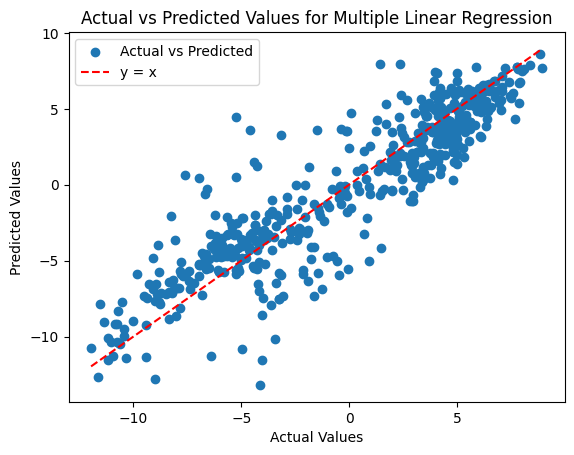

In [6]:
# construct other predictors for the model from parameters
dfs['eps*N'] = dfs['eps'] * dfs['N']
dfs['(eps*N)**2'] = dfs['eps*N']**2
dfs['eps**2'] =  np.square(dfs['eps'])
dfs['e1*e2'] = dfs['e1'] * dfs['e2']
dfs['e1**2'] = np.square(dfs['e1'])
dfs['e2**2'] = np.square(dfs['e2'])
dfs['N**2'] = np.square(dfs['N'])
dfs['N**3'] = np.power(dfs['N'], 3)
dfs['N*e1'] = dfs['N'] * (dfs['e1'] - dfs['e1**2'])
dfs['N*e2'] = dfs['N'] * (dfs['e2'] - dfs['e1**2'])
dfs['(e1+e2)/e3'] = dfs['e1'] + dfs['e2'] / dfs['e3']
dfs['e1*eps'] = dfs['e1'] * dfs['eps']
dfs['e2*eps'] = dfs['e2'] * dfs['eps']
dfs['(e1*eps)**2'] = np.square(dfs['e1*eps'])
dfs['(e2*eps)**2'] = np.square(dfs['e2*eps'])
dfs['N*e1*eps'] = dfs['N'] * dfs['e1*eps']
dfs['N*e2*eps'] = dfs['N'] * dfs['e2*eps']

variables = ['eps', 'N', 'e1', 'e2', 'eps*N', 'e1**2', 'e2**2', 'eps**2', 'e1*e2', 'N*e1', 'N*e2',\
    '(e1+e2)/e3', 'N**2', 'N**3', 'e1*eps', 'e2*eps', '(e1*eps)**2', '(e2*eps)**2', 'N*e1*eps', 'N*e2*eps', 'nodes', 'edges', 'density', '(eps*N)**2']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Multiple Linear Regression')
plt.legend()
plt.show()

Mean Squared Error: 4.848513821760283
R-squared: 0.8297573927304194


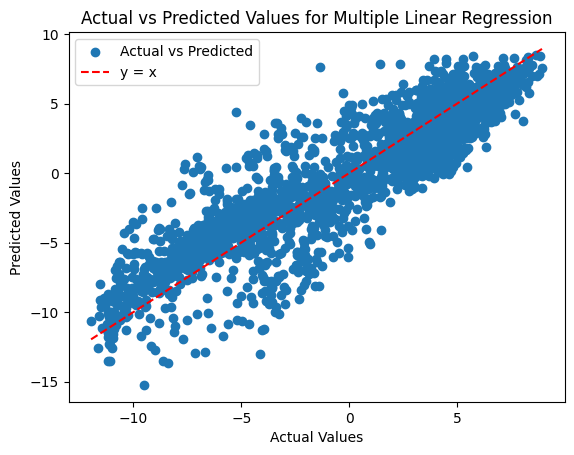

In [7]:
# the model if it had access to all the data, not just training (as good as it's gonna get?)
model2 = LinearRegression()

# Train the model
model2.fit(X, y)

# Make predictions on the test set
y_pred2 = model2.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred2)
r2 = r2_score(y, y_pred2)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual values
plt.scatter(y, y_pred2, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Multiple Linear Regression')
plt.legend()
plt.show()

In [8]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate MSE for each data point
mse_per_point = np.square(residuals)

# Find the indices of the points with the highest MSE
indices_highest_mse = mse_per_point.nlargest(30).index   # Adjust the number of points to display

test_set = dfs.iloc[y_test.index]
test_set['pred'] = y_pred
test_set['diff'] = np.square(test_set['score'] - test_set['pred'])

/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_44893/3960316184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['pred'] = y_pred
/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_44893/3960316184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['diff'] = np.square(test_set['score'] - test_set['pred'])


In [9]:
# largest differences in prediction
test_set.sort_values(by='diff', ascending=False)[:17][['eps', 'N', 'dataset', 'e1', 'e2','pred', 'score', 'diff']]

,eps,N,dataset,e1,e2,pred,score,diff
1981,3.5,5.0,Bitcoin,0.7,0.1,4.485923,-5.257294,94.930283
142,0.5,10.0,Congress,0.1,0.1,-13.182356,-4.151987,81.547558
2456,3.5,30.0,Congress,0.5,0.1,0.666074,-7.588597,68.139594
1979,3.5,5.0,Bitcoin,0.5,0.1,3.595164,-4.598735,67.139981
231,0.5,15.0,Congress,0.1,0.1,-11.512604,-4.038341,55.864615
2367,3.5,25.0,Congress,0.3,0.1,0.434843,-6.946507,54.484319
144,0.5,10.0,Congress,0.1,0.5,-10.165510,-3.447869,45.126704
2066,3.5,10.0,Bitcoin,0.5,0.3,7.964153,1.452163,42.406006
2540,3.5,35.0,Congress,0.3,0.3,3.260534,-3.169320,41.343024
1652,2.0,35.0,Congress,0.7,0.1,-0.290313,-6.578975,39.547271


In [10]:
# After training the model
coefficients = model.coef_  # Coefficients for each feature
intercept = model.intercept_  # Intercept

# Display the equation
equation = f'y = {intercept:.4f}\n'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +"\n"
# print("Linear Regression Equation:")
print(equation)

y = -19.4582
+ 7.1045 * eps
+ 0.6520 * N
+ 13.7991 * e1
+ 7.3708 * e2
-0.0577 * eps*N
-4.3250 * e1**2
-7.3018 * e2**2
-1.1524 * eps**2
-12.5972 * e1*e2
-0.2295 * N*e1
+ 0.1504 * N*e2
+ 0.1299 * (e1+e2)/e3
-0.0127 * N**2
+ 0.0001 * N**3
+ 4.7145 * e1*eps
+ 9.7190 * e2*eps
-1.2105 * (e1*eps)**2
-2.1472 * (e2*eps)**2
-0.0698 * N*e1*eps
-0.1189 * N*e2*eps
-0.0005 * nodes
+ 0.0000 * edges
-0.2199 * density
+ 0.0003 * (eps*N)**2



In [72]:
equation = f'y = {intercept:.4f}'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +" "
# print("Linear Regression Equation:")
print(equation)

y = -15.0388+ 4.7733 * eps + 0.4369 * N + 11.6474 * e1 + 6.0290 * e2 -0.0618 * eps*N -6.5684 * e1**2 -3.5472 * e2**2 -0.6908 * eps**2 -8.2790 * e1*e2 -0.1205 * N*e1 + 0.0618 * N*e2 + 0.0218 * (e1+e2)/e3 -0.0097 * N**2 + 0.0001 * N**3 + 0.0516 * e1*eps + 2.0261 * e2*eps -0.0707 * (e1*eps)**2 -0.4789 * (e2*eps)**2 -0.0227 * N*e1*eps -0.0555 * N*e2*eps + 0.0001 * nodes -0.0000 * edges -0.0000 * density + 0.0003 * (eps*N)**2 


### finding the a good set of parameters using scipy.optimize

In [77]:
from scipy.optimize import minimize

# Define the function to minimize
def objective_function(variables):
    eps = 2.5
    nodes = 4000
    edges = 60000
    density = 0
    N, e1, e2, e3 = variables
    y = -30.4020+ 12.8055 * eps + 0.7659 * N + 20.4504 * e1 + 10.7168 * e2 -0.0921 * eps*N -10.6752 * e1**2 -6.9766 * e2**2 -1.9768 * eps**2 -15.6803 * e1*e2 -0.2167 * N*e1 + 0.0960 * N*e2 + 0.1402 * (e1+e2)/e3 -0.0148 * N**2 + 0.0001 * N**3 + 3.1916 * e1*eps + 7.0388 * e2*eps -0.6629 * (e1*eps)**2 -1.6006 * (e2*eps)**2 -0.0997 * N*e1*eps -0.1143 * N*e2*eps + 0.0016 * nodes -0.0001 * edges -0.0000 * density + 0.0004 * (eps*N)**2 

    return -y

# Initial guess for variable values
initial_guess = [30.0, 0.4, 0.4, 0.2]

# Define bounds for the variables if needed
bounds = [ (0, 70), (0.01, 1), (0.1, 1), (0.1, 1)]

# Perform the minimization
result = minimize(objective_function, initial_guess, bounds=bounds, constraints={'type': 'eq', 'fun': lambda x: x[1] + x[2] + x[3]- 1.0 })

# Extract the optimal variable values
optimal_values = result.x

print("Optimal Variable Values:", optimal_values)
print("Minimum Value of y:", result.fun)

Optimal Variable Values: [11.95488459  0.41151761  0.48848239  0.1       ]
Minimum Value of y: -8.151483273200043


### Selecting features automatically with RFE (doesn't actually work as well)

In [548]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


In [613]:
variables = ['eps', 'N', 'e1', 'e2', 'nodes', 'edges']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Create polynomial features
degree = 5  # Set the degree of polynomial features
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Initialize the linear regression model
model = LinearRegression()

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
selector = RFE(estimator=model, step=1, n_features_to_select = 25)

# Fit RFE on the polynomial features
selector = selector.fit(X_poly, y)

# # Get the selected features
selected_features_indices = selector.support_
selected_features = X_poly[:,selected_features_indices]

In [614]:
len(selected_features_indices)

462

In [616]:
poly.powers_[selected_features_indices]

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 0, 1],
       [0, 4, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 0],
       [0, 1, 0, 2, 0, 1],
       [3, 1, 0, 0, 1, 0],
       [3, 0, 1, 0, 0, 1],
       [2, 2, 0, 0, 1, 0],
       [2, 1, 1, 0, 0, 1],
       [2, 0, 1, 0, 2, 0],
       [2, 0, 0, 2, 0, 1],
       [2, 0, 0, 1, 2, 0],
       [1, 2, 1, 0, 1, 0],
       [1, 2, 0, 1, 1, 0],
       [1, 1, 2, 0, 0, 1],
       [1, 1, 0, 2, 0, 1],
       [1, 0, 1, 1, 2, 0],
       [1, 0, 1, 1, 1, 1],
       [0, 2, 2, 0, 1, 0],
       [0, 2, 2, 0, 0, 1],
       [0, 2, 1, 1, 0, 1],
       [0, 2, 0, 2, 1, 0],
       [0, 1, 0, 3, 0, 1]])

In [617]:
X_feat = pd.DataFrame()
for ic, combo in enumerate(poly.powers_[selected_features_indices]):
    vars = []
    for i, pow in enumerate(combo):
        if pow > 0:
            var = X.columns[i] 
            if pow > 1:
                var += "**" + str(pow) 
            vars.append(var)
            
    name = '+'.join(vars)
            
    X_feat[name] = X.apply(lambda row: 
        np.sum([np.power(row[X.columns[ri]], combo[ri]) for ri in range(len(combo)) if combo[ri] > 0]), axis=1)
    # print(np.power(X, combo))
    # X_feat[name] = np.power(X, combo)
  
X_feat  

,eps,N,eps**2+e2+edges,eps+N+e1+edges,N**4,N**2+e2+nodes,N+e2**2+edges,eps**3+N+nodes,eps**3+e1+edges,eps**2+N**2+nodes,...,eps+N**2+e2+nodes,eps+N+e1**2+edges,eps+N+e2**2+edges,eps+e1+e2+nodes**2,eps+e1+e2+nodes+edges,N**2+e1**2+nodes,N**2+e1**2+edges,N**2+e1+e2+edges,N**2+e2**2+nodes,N+e2**3+edges
0,0.5,5.0,118489.35,118494.6,625.0,12033.1,118494.01,12013.125,118489.225,12033.25,...,12033.6,118494.51,118494.51,144192064.7,130497.7,12033.01,118514.01,118514.2,12033.01,118494.001
1,0.5,5.0,118489.45,118494.6,625.0,12033.2,118494.04,12013.125,118489.225,12033.25,...,12033.7,118494.51,118494.54,144192064.8,130497.8,12033.01,118514.01,118514.3,12033.04,118494.008
2,0.5,5.0,118489.55,118494.6,625.0,12033.3,118494.09,12013.125,118489.225,12033.25,...,12033.8,118494.51,118494.59,144192064.9,130497.9,12033.01,118514.01,118514.4,12033.09,118494.027
3,0.5,5.0,118489.65,118494.6,625.0,12033.4,118494.16,12013.125,118489.225,12033.25,...,12033.9,118494.51,118494.66,144192065.0,130498.0,12033.01,118514.01,118514.5,12033.16,118494.064
4,0.5,5.0,118489.75,118494.6,625.0,12033.5,118494.25,12013.125,118489.225,12033.25,...,12034.0,118494.51,118494.75,144192065.1,130498.1,12033.01,118514.01,118514.6,12033.25,118494.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,3.5,35.0,88246.65,88272.9,1500625.0,5264.4,88269.16,4116.875,88277.275,5276.25,...,5267.9,88272.66,88272.66,16313525.3,92277.3,5264.16,89459.16,89459.8,5264.16,88269.064
1484,3.5,35.0,88246.75,88272.9,1500625.0,5264.5,88269.25,4116.875,88277.275,5276.25,...,5268.0,88272.66,88272.75,16313525.4,92277.4,5264.16,89459.16,89459.9,5264.25,88269.125
1485,3.5,35.0,88246.35,88273.0,1500625.0,5264.1,88269.01,4116.875,88277.375,5276.25,...,5267.6,88272.75,88272.51,16313525.1,92277.1,5264.25,89459.25,89459.6,5264.01,88269.001
1486,3.5,35.0,88246.55,88273.0,1500625.0,5264.3,88269.09,4116.875,88277.375,5276.25,...,5267.8,88272.75,88272.59,16313525.3,92277.3,5264.25,89459.25,89459.8,5264.09,88269.027
